In [ ]:
# importing libraries

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import FeatureUnion
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, precision_recall_fscore_support
from sklearn.externals import joblib
import matplotlib.pyplot as plt
import warnings

%config InlineBackend.figure_format='retina'
warnings.filterwarnings("ignore")

In [2]:
# defining functions

def Get_Feature_Importances(pipeline):
    feature_names = pipeline.named_steps['features'].transformer_list[0][1].named_steps['vectorizer'].get_feature_names()
    feature_names.extend(['word_count', 'char_count', 'word_density', 'total_length', 'capitals', 'caps_vs_length', 'num_exclamation_marks' ,'num_unique_words', 'words_vs_unique'])
    #print(len(feature_names))
    
    coefficients = pipeline[1].coef_

    importances = []
    for coef in coefficients:
        importances.append(list(coefficients[0]))
    importances = importances[0]
    #print(len(importances))
    #print(importances)
    
    feature_importances = dict()
    for i in range(len(feature_names)):
        feature_importances[feature_names[i]] = importances[i]
        #print(importances[i])

    #print(len(feature_importances))
    #print(feature_importances)
    
    return feature_importances

def Plot_Feature_Importances(feature_importances, top_features=10):
    top_positive_coefficients = dict(sorted(feature_importances.items(), key=lambda x: x[1], reverse=True)[:top_features])
    top_negative_coefficients = dict(sorted(feature_importances.items(), key=lambda x: x[1], reverse=False)[:top_features])
    top_coefficients = {**top_positive_coefficients , **top_negative_coefficients}
    top_coefficients = dict(sorted(top_coefficients.items(), key=lambda x: x[1], reverse=False))
    #type(top_coefficients)
    #top_coefficients

    plt.figure(figsize=(15, 5))
    colors = ['red' if c < 0 else 'blue' for c in top_coefficients.values()]
    plt.bar(np.arange(2 * top_features)+1, top_coefficients.values(), color=colors)
    feature_names = list(top_coefficients.keys())
    plt.xticks(np.arange(1, 1 + 2 * top_features), feature_names, rotation=60, ha='right')
    plt.show()

In [3]:
# read the data

df = pd.read_csv('sampdf_feat.csv')
df.shape

(54870, 19)

In [4]:
subdf = df[df['toxic']==1]
subdf.shape

(21383, 19)

In [5]:
categories = ['severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

In [6]:
# Create X and y dataframe

X = subdf.loc[:, ['cleaned_comment_text', 'word_count', 'char_count', 'word_density', 'total_length',
               'capitals', 'caps_vs_length', 'num_exclamation_marks', 'num_unique_words', 'words_vs_unique'
               ]]
y = subdf[categories]

In [7]:
#Split train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=2019)

print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)

X_train: (17106, 10)
y_train: (17106, 5)
X_test: (4277, 10)
y_test: (4277, 5)


In [8]:
# define classes for selecting features

class TextSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on text columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]

In [9]:
# creating separate Pipelines for each feature

word_count =  Pipeline([
                ('selector', NumberSelector(key='word_count')),
                ('standard', StandardScaler())
            ])

word_count.fit_transform(X_train)

char_count =  Pipeline([
                ('selector', NumberSelector(key='char_count')),
                ('standard', StandardScaler())
            ])

char_count.fit_transform(X_train)

word_density =  Pipeline([
                ('selector', NumberSelector(key='word_density')),
                ('standard', StandardScaler())
            ])

word_density.fit_transform(X_train)

total_length =  Pipeline([
                ('selector', NumberSelector(key='total_length')),
                ('standard', StandardScaler())
            ])

total_length.fit_transform(X_train)

capitals =  Pipeline([
                ('selector', NumberSelector(key='capitals')),
                ('standard', StandardScaler())
            ])

capitals.fit_transform(X_train)

caps_vs_length =  Pipeline([
                ('selector', NumberSelector(key='caps_vs_length')),
                ('standard', StandardScaler())
            ])

caps_vs_length.fit_transform(X_train)

num_exclamation_marks =  Pipeline([
                ('selector', NumberSelector(key='num_exclamation_marks')),
                ('standard', StandardScaler())
            ])

num_exclamation_marks.fit_transform(X_train)

num_unique_words =  Pipeline([
                ('selector', NumberSelector(key='num_unique_words')),
                ('standard', StandardScaler())
            ])

num_unique_words.fit_transform(X_train)

words_vs_unique =  Pipeline([
                ('selector', NumberSelector(key='words_vs_unique')),
                ('standard', StandardScaler())
            ])

words_vs_unique.fit_transform(X_train)

array([[ 0.3433602 ],
       [-4.5823279 ],
       [ 0.17315415],
       ...,
       [ 0.25732198],
       [ 0.25732198],
       [-0.25890734]])

##### USING TF-IDF VECTORIZER

In [10]:
# TF-IDF vectorizer pipeline

text = Pipeline([
            ('selector', TextSelector(key='cleaned_comment_text')),
            ('vectorizer', TfidfVectorizer(stop_words='english'))
        ])

text.fit_transform(X_train)

<17106x30934 sparse matrix of type '<class 'numpy.float64'>'
	with 245326 stored elements in Compressed Sparse Row format>

In [11]:
# creating feature union

feats = FeatureUnion([('text', text), 
                      ('word_count', word_count),
                      ('char_count', char_count),
                      ('word_density', word_density),
                      ('total_length', total_length),
                      ('capitals', capitals), 
                      ('caps_vs_length', caps_vs_length), 
                      ('num_exclamation_marks', num_exclamation_marks), 
                      ('num_unique_words', num_unique_words), 
                      ('words_vs_unique', words_vs_unique)])

feature_processing = Pipeline([('feats', feats)])
feature_processing.fit_transform(X_train)

<17106x30943 sparse matrix of type '<class 'numpy.float64'>'
	with 399280 stored elements in Compressed Sparse Row format>

In [12]:
# defining the model 

range_C = [0.1, 0.2, 0.5, 1.0, 2.0]
pipelines = []

for C  in range_C:
    LR = LogisticRegression(C=C)

    pipeline = Pipeline([
        ('features',feats),
        ('classifier', LR),
    ])
    
    pipelines.append(pipeline)

In [13]:
summary = pd.DataFrame(columns=['C', 'Avg Accuracy - Train', 'Micro Precision - Train', 
                                'Micro Recall - Train', 'Micro F1-score - Train',
                                'Avg Accuracy - Test', 'Micro Precision - Test', 
                                'Micro Recall - Test', 'Micro F1-score - Test'])

In [14]:
# train, predict and evaluate on training and test data

for i in range(len(pipelines)):
    
    print('Calculating for C = ', range_C[i])
    
    train_TP = list()
    train_FP = list()
    train_FN = list()
    train_TN = list()
    train_accuracy = list()
    train_precision = list()
    train_recall = list()
    train_f1_score = list()
    
    test_TP = list()
    test_FP = list()
    test_FN = list()
    test_TN = list()
    test_accuracy = list()
    test_precision = list()
    test_recall = list()
    test_f1_score = list()
    
    for category in categories:
        
        print('\t... Processing {}'.format(category))
        
        # train the model
        print('\tTraining...')
        pipelines[i].fit(X_train, y_train[category])

        print('\t\tCalculating Training Metrics for C = ', range_C[i])
        train_pred = pipelines[i].predict(X_train)
        
        cm = confusion_matrix(y_train[category], train_pred)
        TN_i = cm[0][0]
        FP_i = cm[0][1]
        FN_i = cm[1][0]
        TP_i = cm[1][1]

        train_TP.append(TP_i)
        train_FP.append(FP_i)
        train_FN.append(FN_i)
        train_TN.append(TN_i)
        
        accuracy_i = (TP_i + TN_i) / (TP_i + TN_i + FN_i + FP_i)
        train_accuracy.append(accuracy_i)
        
        print('\t\tCalculating Testing Metrics for C = ', range_C[i])
        test_pred = pipelines[i].predict(X_test)
        
        cm = confusion_matrix(y_test[category], test_pred)
        TN_i = cm[0][0]
        FP_i = cm[0][1]
        FN_i = cm[1][0]
        TP_i = cm[1][1]

        test_TP.append(TP_i)
        test_FP.append(FP_i)
        test_FN.append(FN_i)
        test_TN.append(TN_i)
        
        accuracy_i = (TP_i + TN_i) / (TP_i + TN_i + FN_i + FP_i)
        test_accuracy.append(accuracy_i)
        
    train_avg_accuracy = np.average(train_accuracy)
    train_precision = sum(train_TP) / (sum(train_TP) + sum(train_FP))
    train_recall = sum(train_TP) / (sum(train_TP) + sum(train_FN))
    train_f1_score = 2 * train_precision * train_recall / (train_precision + train_recall)
    
    test_avg_accuracy = np.average(test_accuracy)
    test_precision = sum(test_TP) / (sum(test_TP) + sum(test_FP))
    test_recall = sum(test_TP) / (sum(test_TP) + sum(test_FN))
    test_f1_score = 2 * test_precision * test_recall / (test_precision + test_recall)
    
    summary.at[i, 'C'] = range_C[i]
    summary.at[i, 'Avg Accuracy - Train'] = np.round(100*train_avg_accuracy, 2)
    summary.at[i, 'Micro Precision - Train'] = np.round(100*train_precision, 2)
    summary.at[i, 'Micro Recall - Train'] = np.round(100*train_recall, 2)
    summary.at[i, 'Micro F1-score - Train'] = np.round(100*train_f1_score, 2)
    
    summary.at[i, 'Avg Accuracy - Test'] = np.round(100*test_avg_accuracy, 2)
    summary.at[i, 'Micro Precision - Test'] = np.round(100*test_precision, 2)
    summary.at[i, 'Micro Recall - Test'] = np.round(100*test_recall, 2)
    summary.at[i, 'Micro F1-score - Test'] = np.round(100*test_f1_score, 2)
    
display(summary)

Calculating for C =  0.1
	... Processing severe_toxic
	Training...
		Calculating Training Metrics for C =  0.1
		Calculating Testing Metrics for C =  0.1
	... Processing obscene
	Training...
		Calculating Training Metrics for C =  0.1
		Calculating Testing Metrics for C =  0.1
	... Processing threat
	Training...
		Calculating Training Metrics for C =  0.1
		Calculating Testing Metrics for C =  0.1
	... Processing insult
	Training...
		Calculating Training Metrics for C =  0.1
		Calculating Testing Metrics for C =  0.1
	... Processing identity_hate
	Training...
		Calculating Training Metrics for C =  0.1
		Calculating Testing Metrics for C =  0.1
Calculating for C =  0.2
	... Processing severe_toxic
	Training...
		Calculating Training Metrics for C =  0.2
		Calculating Testing Metrics for C =  0.2
	... Processing obscene
	Training...
		Calculating Training Metrics for C =  0.2
		Calculating Testing Metrics for C =  0.2
	... Processing threat
	Training...
		Calculating Training Metrics f

,C,Avg Accuracy - Train,Micro Precision - Train,Micro Recall - Train,Micro F1-score - Train,Avg Accuracy - Test,Micro Precision - Test,Micro Recall - Test,Micro F1-score - Test
0,0.1,86.84,83.93,59.14,69.39,86.23,80.15,58.67,67.75
1,0.2,87.68,85.5,61.61,71.61,86.67,80.28,60.87,69.24
2,0.5,89.03,87.08,66.37,75.32,87.05,79.94,63.36,70.69
3,1,90.4,88.39,71.29,78.93,87.16,79.22,64.95,71.38
4,2,92.11,90.14,77.15,83.14,87.21,78.41,66.38,71.89


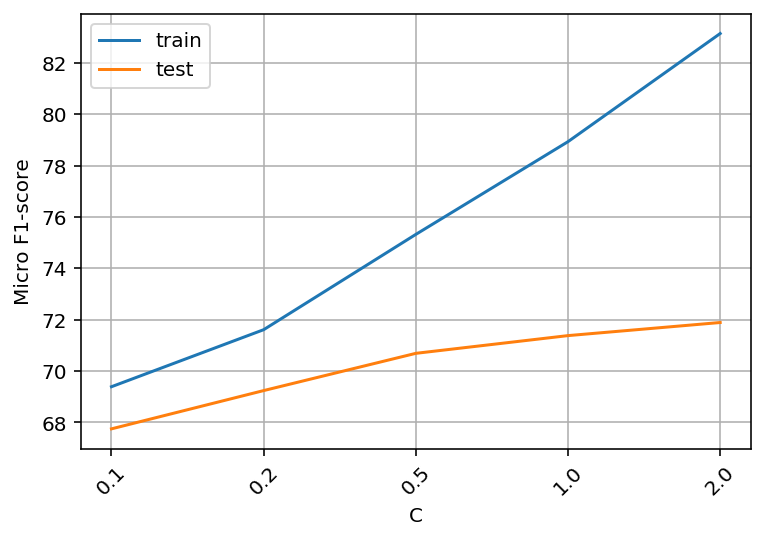

In [15]:
# plot train F1-score and test F1-score

fig = plt.figure(1)
ax  = fig.add_subplot(111)
a = np.arange(len(summary))

plt.plot(summary['Micro F1-score - Train'], label='train')
plt.plot(summary['Micro F1-score - Test'], label='test')
ax.xaxis.set_ticks(a)
ax.xaxis.set_ticklabels(range_C, rotation=45)
plt.xlabel('C')
plt.ylabel('Micro F1-score', rotation=90)
plt.legend()
plt.grid(True)

Test score is highest at C = 2.0. So we select 2.0 for C.

Calculating for C = 2.0
	... Processing severe_toxic
	Training...


array([[3815,   66],
       [ 302,   94]])

              precision    recall  f1-score   support

           0       0.93      0.98      0.95      3881
           1       0.59      0.24      0.34       396

    accuracy                           0.91      4277
   macro avg       0.76      0.61      0.65      4277
weighted avg       0.90      0.91      0.90      4277



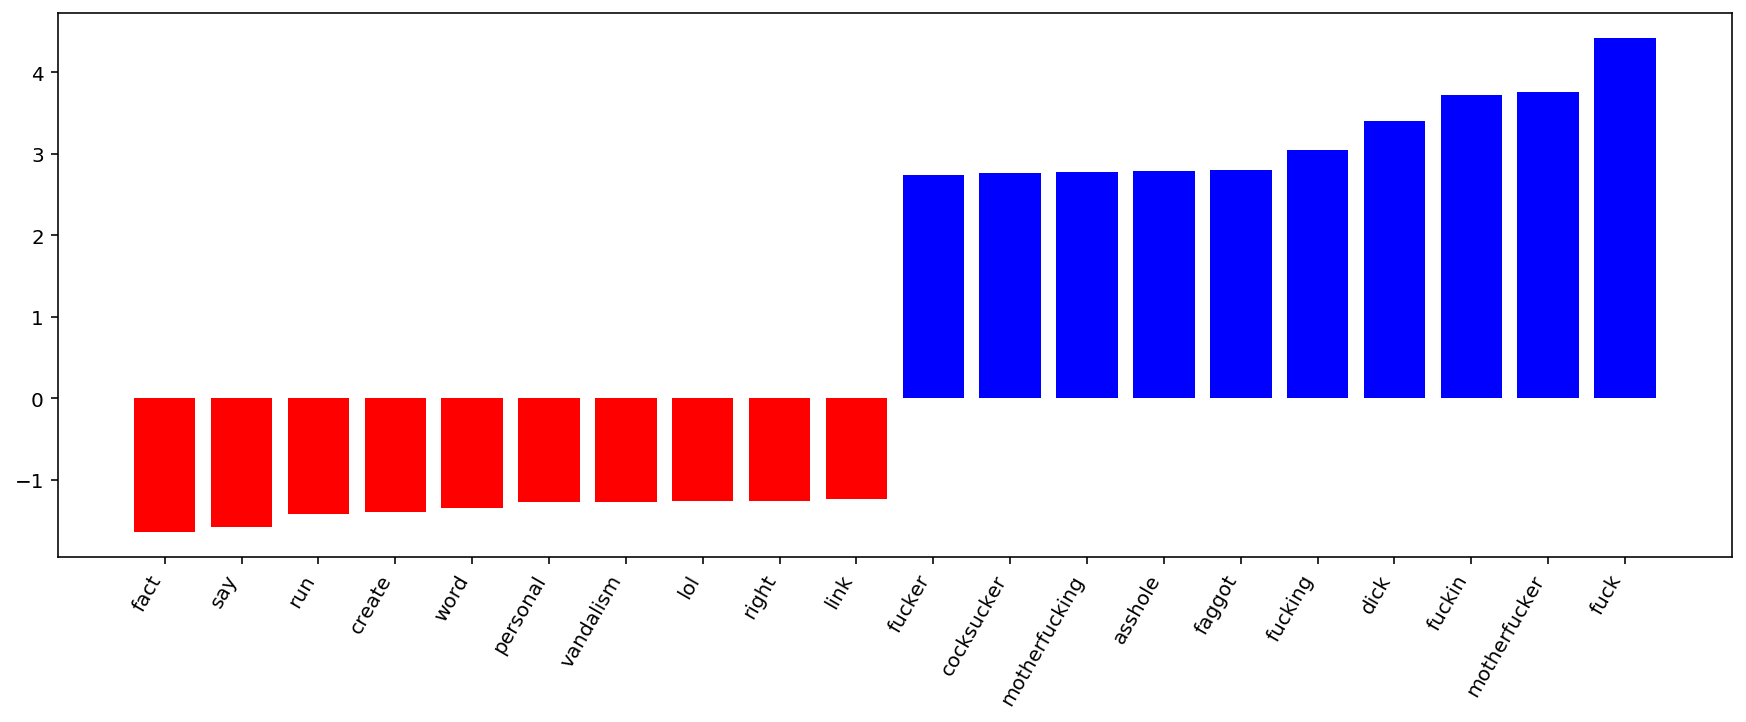

	... Processing obscene
	Training...


array([[1692,  329],
       [ 498, 1758]])

              precision    recall  f1-score   support

           0       0.77      0.84      0.80      2021
           1       0.84      0.78      0.81      2256

    accuracy                           0.81      4277
   macro avg       0.81      0.81      0.81      4277
weighted avg       0.81      0.81      0.81      4277



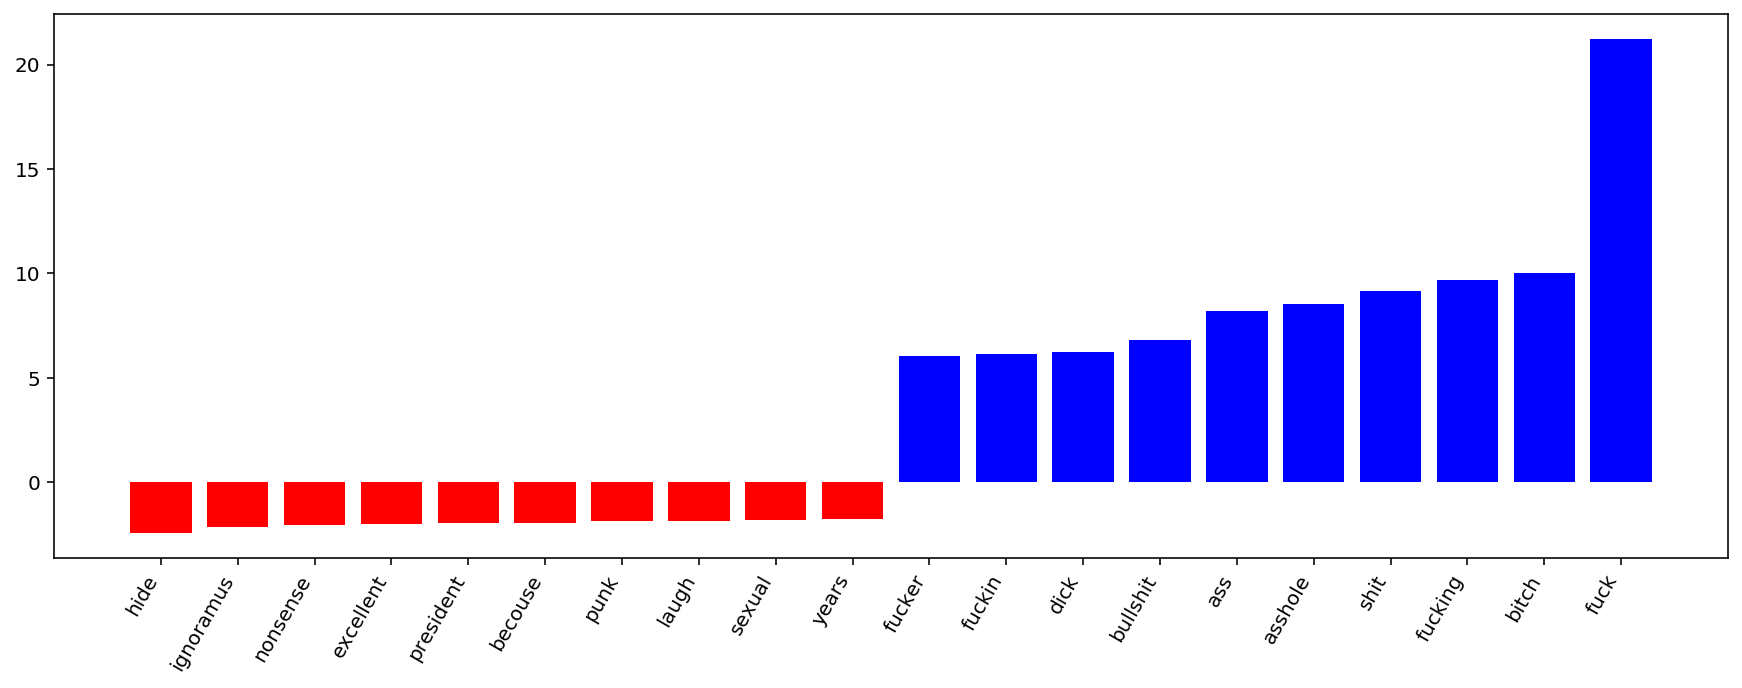

	... Processing threat
	Training...


array([[4141,   19],
       [  86,   31]])

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      4160
           1       0.62      0.26      0.37       117

    accuracy                           0.98      4277
   macro avg       0.80      0.63      0.68      4277
weighted avg       0.97      0.98      0.97      4277



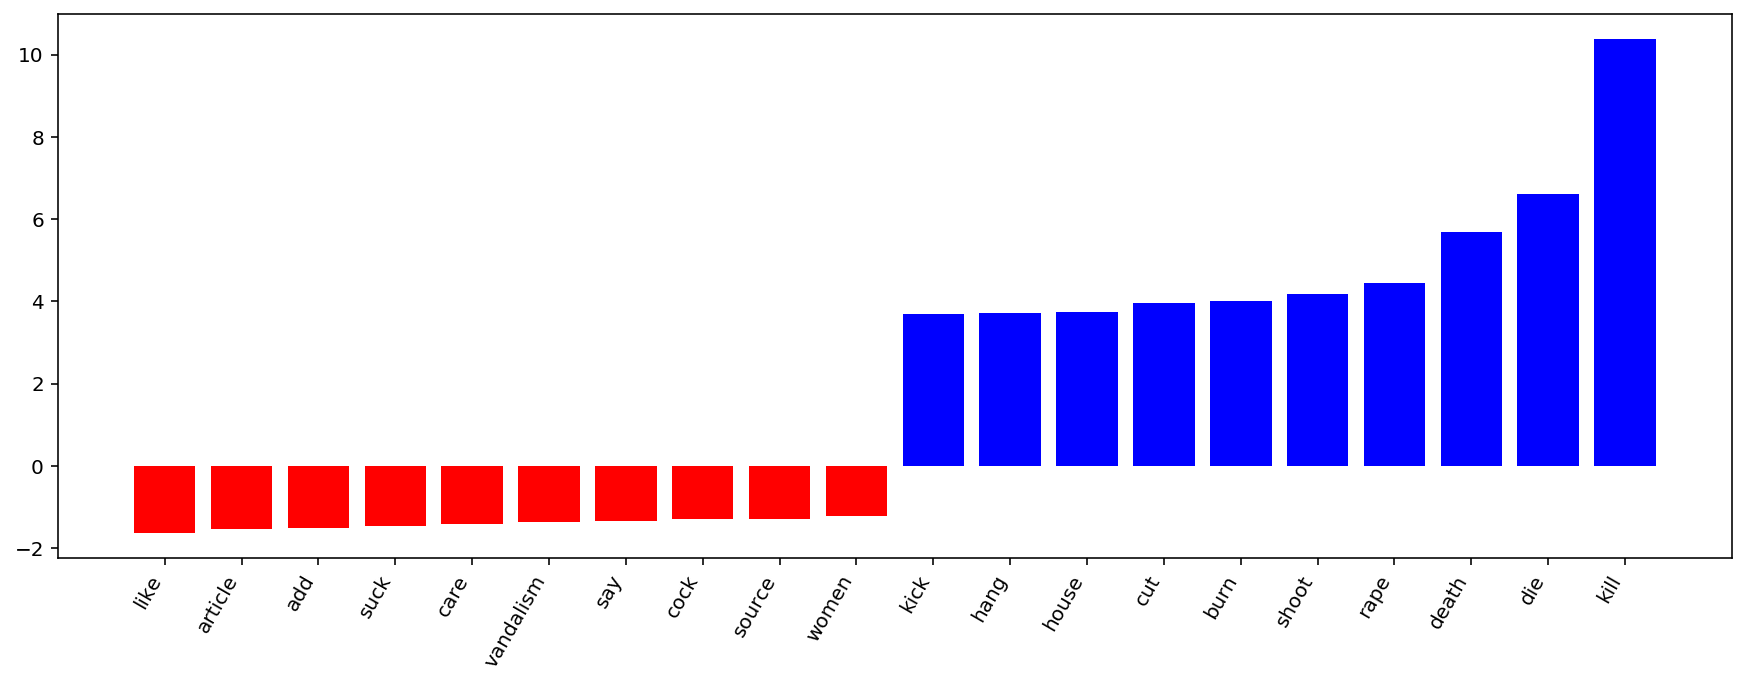

	... Processing insult
	Training...


array([[1659,  500],
       [ 643, 1475]])

              precision    recall  f1-score   support

           0       0.72      0.77      0.74      2159
           1       0.75      0.70      0.72      2118

    accuracy                           0.73      4277
   macro avg       0.73      0.73      0.73      4277
weighted avg       0.73      0.73      0.73      4277



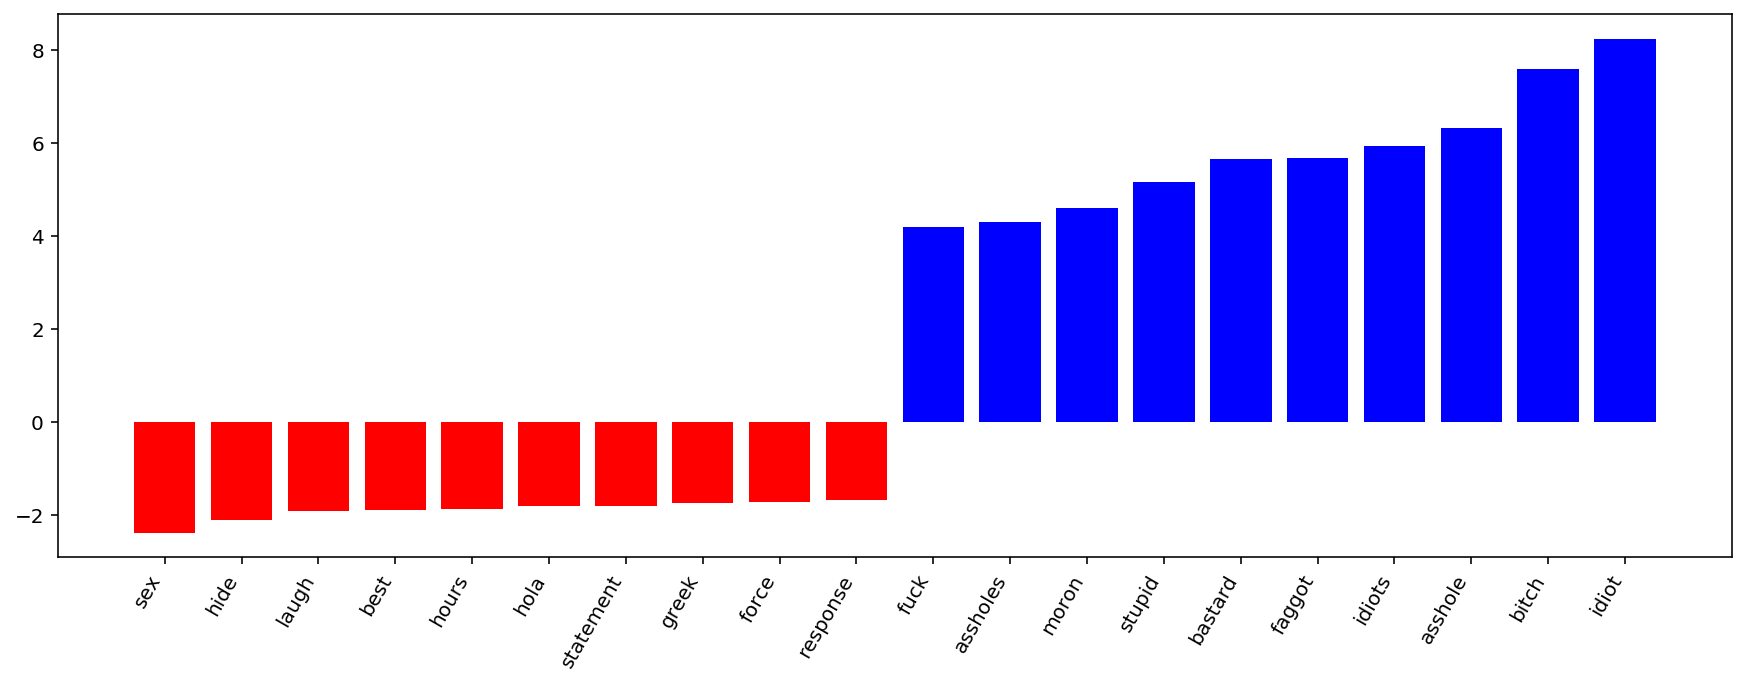

	... Processing identity_hate
	Training...


array([[3845,   49],
       [ 243,  140]])

              precision    recall  f1-score   support

           0       0.94      0.99      0.96      3894
           1       0.74      0.37      0.49       383

    accuracy                           0.93      4277
   macro avg       0.84      0.68      0.73      4277
weighted avg       0.92      0.93      0.92      4277



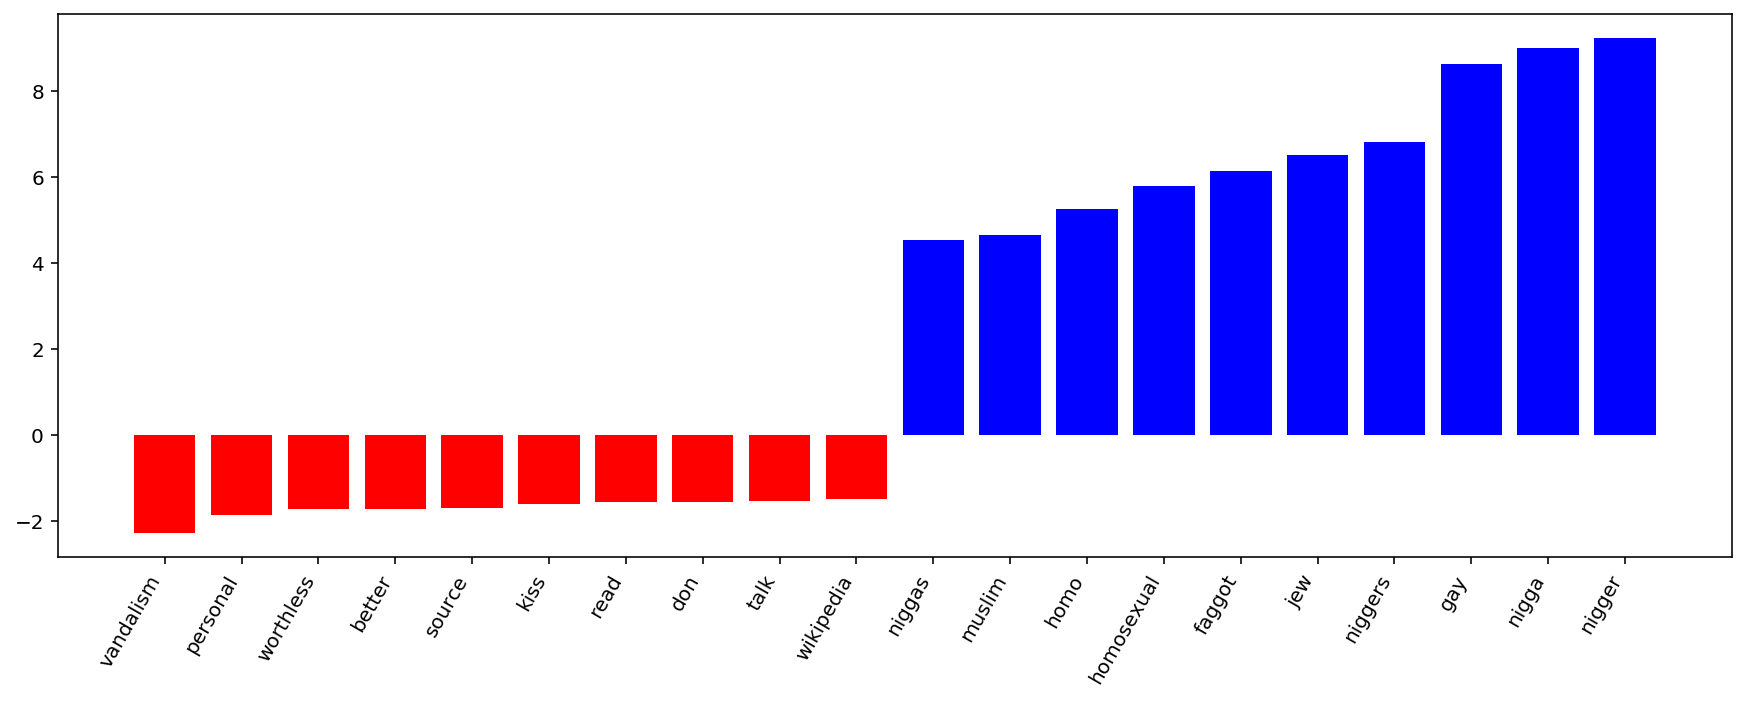


Micro Precision: 78.41%
Micro Recall: 66.38%
Micro F1-score: 71.89%
Average Accuracy: 87.21%


In [16]:
print('Calculating for C = 2.0')

test_TP = list()
test_FP = list()
test_FN = list()
test_TN = list()
test_accuracy = list()
test_precision = list()
test_recall = list()
test_f1_score = list()

for category in categories:
    print('\t... Processing {}'.format(category))

    # train the model
    print('\tTraining...')
    pipelines[4].fit(X_train, y_train[category])
    test_pred = pipelines[4].predict(X_test)

    display(confusion_matrix(y_test[category], test_pred))
    print(classification_report(y_test[category], test_pred))
    
    cm = confusion_matrix(y_test[category], test_pred)
    TN_i = cm[0][0]
    FP_i = cm[0][1]
    FN_i = cm[1][0]
    TP_i = cm[1][1]

    test_TP.append(TP_i)
    test_FP.append(FP_i)
    test_FN.append(FN_i)
    test_TN.append(TN_i)

    accuracy_i = (TP_i + TN_i) / (TP_i + TN_i + FN_i + FP_i)
    test_accuracy.append(accuracy_i)
    
    # feature importance
    feature_importances = Get_Feature_Importances(pipelines[4])
    Plot_Feature_Importances(feature_importances) 
    
    # saving the model
    filename = 'TFIDF_LR_Level_2_' + str(category) + '.joblib'
    joblib.dump(pipelines[4], filename)

test_avg_accuracy = np.average(test_accuracy)
test_precision = sum(test_TP) / (sum(test_TP) + sum(test_FP))
test_recall = sum(test_TP) / (sum(test_TP) + sum(test_FN))
test_f1_score = 2 * test_precision * test_recall / (test_precision + test_recall)

print("\nMicro Precision: {}%".format(round(100*test_precision, 2)))
print("Micro Recall: {}%".format(round(100*test_recall, 2)))
print("Micro F1-score: {}%".format(round(100*test_f1_score, 2)))
print("Average Accuracy: {}%".format(round(100*test_avg_accuracy, 2)))

##### USING BINARY VECTORIZER

In [17]:
# Binary vectorizer pipeline

text = Pipeline([
            ('selector', TextSelector(key='cleaned_comment_text')),
            ('vectorizer', TfidfVectorizer(stop_words='english', binary=True, use_idf=False, norm=False))
        ])

text.fit_transform(X_train)

<17106x30934 sparse matrix of type '<class 'numpy.float64'>'
	with 245326 stored elements in Compressed Sparse Row format>

In [18]:
# creating feature union

feats = FeatureUnion([('text', text), 
                      ('word_count', word_count),
                      ('char_count', char_count),
                      ('word_density', word_density),
                      ('total_length', total_length),
                      ('capitals', capitals), 
                      ('caps_vs_length', caps_vs_length), 
                      ('num_exclamation_marks', num_exclamation_marks), 
                      ('num_unique_words', num_unique_words), 
                      ('words_vs_unique', words_vs_unique)])

feature_processing = Pipeline([('feats', feats)])
feature_processing.fit_transform(X_train)

<17106x30943 sparse matrix of type '<class 'numpy.float64'>'
	with 399280 stored elements in Compressed Sparse Row format>

In [19]:
# defining the model 

range_C = [0.1, 0.2, 0.5, 1.0, 2.0]
pipelines = []

for C  in range_C:
    LR = LogisticRegression(C=C)

    pipeline = Pipeline([
        ('features',feats),
        ('classifier', LR),
    ])
    
    pipelines.append(pipeline)

In [20]:
summary = pd.DataFrame(columns=['C', 'Avg Accuracy - Train', 'Micro Precision - Train', 
                                'Micro Recall - Train', 'Micro F1-score - Train',
                                'Avg Accuracy - Test', 'Micro Precision - Test', 
                                'Micro Recall - Test', 'Micro F1-score - Test'])

In [21]:
# train, predict and evaluate on training and test data

for i in range(len(pipelines)):
    
    print('Calculating for C = ', range_C[i])
    
    train_TP = list()
    train_FP = list()
    train_FN = list()
    train_TN = list()
    train_accuracy = list()
    train_precision = list()
    train_recall = list()
    train_f1_score = list()
    
    test_TP = list()
    test_FP = list()
    test_FN = list()
    test_TN = list()
    test_accuracy = list()
    test_precision = list()
    test_recall = list()
    test_f1_score = list()
    
    for category in categories:
        
        print('\t... Processing {}'.format(category))
        
        # train the model
        print('\tTraining...')
        pipelines[i].fit(X_train, y_train[category])

        print('\t\tCalculating Training Metrics for C = ', range_C[i])
        train_pred = pipelines[i].predict(X_train)
        
        cm = confusion_matrix(y_train[category], train_pred)
        TN_i = cm[0][0]
        FP_i = cm[0][1]
        FN_i = cm[1][0]
        TP_i = cm[1][1]

        train_TP.append(TP_i)
        train_FP.append(FP_i)
        train_FN.append(FN_i)
        train_TN.append(TN_i)
        
        accuracy_i = (TP_i + TN_i) / (TP_i + TN_i + FN_i + FP_i)
        train_accuracy.append(accuracy_i)
        
        print('\t\tCalculating Testing Metrics for C = ', range_C[i])
        test_pred = pipelines[i].predict(X_test)
        
        cm = confusion_matrix(y_test[category], test_pred)
        TN_i = cm[0][0]
        FP_i = cm[0][1]
        FN_i = cm[1][0]
        TP_i = cm[1][1]

        test_TP.append(TP_i)
        test_FP.append(FP_i)
        test_FN.append(FN_i)
        test_TN.append(TN_i)
        
        accuracy_i = (TP_i + TN_i) / (TP_i + TN_i + FN_i + FP_i)
        test_accuracy.append(accuracy_i)
        
    train_avg_accuracy = np.average(train_accuracy)
    train_precision = sum(train_TP) / (sum(train_TP) + sum(train_FP))
    train_recall = sum(train_TP) / (sum(train_TP) + sum(train_FN))
    train_f1_score = 2 * train_precision * train_recall / (train_precision + train_recall)
    
    test_avg_accuracy = np.average(test_accuracy)
    test_precision = sum(test_TP) / (sum(test_TP) + sum(test_FP))
    test_recall = sum(test_TP) / (sum(test_TP) + sum(test_FN))
    test_f1_score = 2 * test_precision * test_recall / (test_precision + test_recall)
    
    summary.at[i, 'C'] = range_C[i]
    summary.at[i, 'Avg Accuracy - Train'] = np.round(100*train_avg_accuracy, 2)
    summary.at[i, 'Micro Precision - Train'] = np.round(100*train_precision, 2)
    summary.at[i, 'Micro Recall - Train'] = np.round(100*train_recall, 2)
    summary.at[i, 'Micro F1-score - Train'] = np.round(100*train_f1_score, 2)
    
    summary.at[i, 'Avg Accuracy - Test'] = np.round(100*test_avg_accuracy, 2)
    summary.at[i, 'Micro Precision - Test'] = np.round(100*test_precision, 2)
    summary.at[i, 'Micro Recall - Test'] = np.round(100*test_recall, 2)
    summary.at[i, 'Micro F1-score - Test'] = np.round(100*test_f1_score, 2)
    
display(summary)

Calculating for C =  0.1
	... Processing severe_toxic
	Training...
		Calculating Training Metrics for C =  0.1
		Calculating Testing Metrics for C =  0.1
	... Processing obscene
	Training...
		Calculating Training Metrics for C =  0.1
		Calculating Testing Metrics for C =  0.1
	... Processing threat
	Training...
		Calculating Training Metrics for C =  0.1
		Calculating Testing Metrics for C =  0.1
	... Processing insult
	Training...
		Calculating Training Metrics for C =  0.1
		Calculating Testing Metrics for C =  0.1
	... Processing identity_hate
	Training...
		Calculating Training Metrics for C =  0.1
		Calculating Testing Metrics for C =  0.1
Calculating for C =  0.2
	... Processing severe_toxic
	Training...
		Calculating Training Metrics for C =  0.2
		Calculating Testing Metrics for C =  0.2
	... Processing obscene
	Training...
		Calculating Training Metrics for C =  0.2
		Calculating Testing Metrics for C =  0.2
	... Processing threat
	Training...
		Calculating Training Metrics f

,C,Avg Accuracy - Train,Micro Precision - Train,Micro Recall - Train,Micro F1-score - Train,Avg Accuracy - Test,Micro Precision - Test,Micro Recall - Test,Micro F1-score - Test
0,0.1,89.89,86.04,71.55,78.13,87.47,79.91,65.67,72.1
1,0.2,91.31,87.67,76.29,81.59,87.57,79.24,67.15,72.7
2,0.5,93.39,90.53,82.41,86.28,87.58,78.36,68.56,73.13
3,1,94.92,92.57,86.82,89.6,87.33,77.29,68.79,72.79
4,2,96.39,94.46,91.03,92.71,87.03,76.03,69.2,72.45


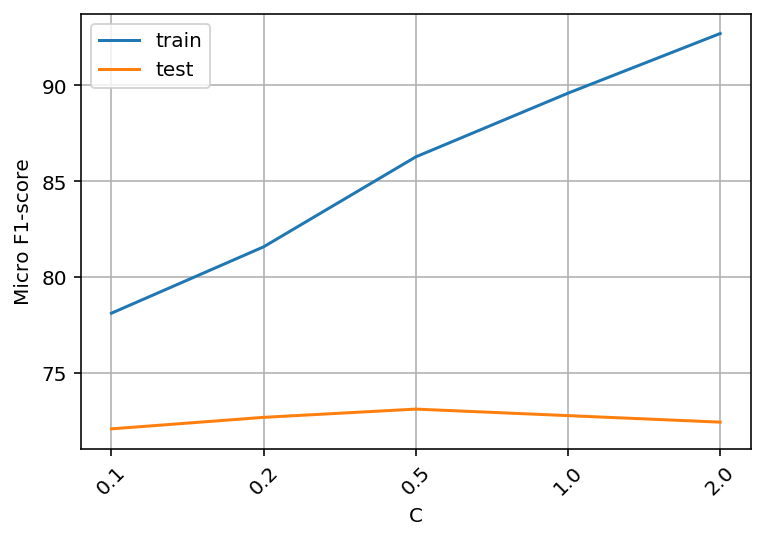

In [22]:
# plot train F1-score and test F1-score

fig = plt.figure(1)
ax  = fig.add_subplot(111)
a = np.arange(len(summary))

plt.plot(summary['Micro F1-score - Train'], label='train')
plt.plot(summary['Micro F1-score - Test'], label='test')
ax.xaxis.set_ticks(a)
ax.xaxis.set_ticklabels(range_C, rotation=45)
plt.xlabel('C')
plt.ylabel('Micro F1-score', rotation=90)
plt.legend()
plt.grid(True)

Since the test score is highest at C = 0.5, we will select 0.5 for C.

Calculating for C = 0.5
	... Processing severe_toxic
	Training...


array([[3829,   52],
       [ 311,   85]])

              precision    recall  f1-score   support

           0       0.92      0.99      0.95      3881
           1       0.62      0.21      0.32       396

    accuracy                           0.92      4277
   macro avg       0.77      0.60      0.64      4277
weighted avg       0.90      0.92      0.90      4277



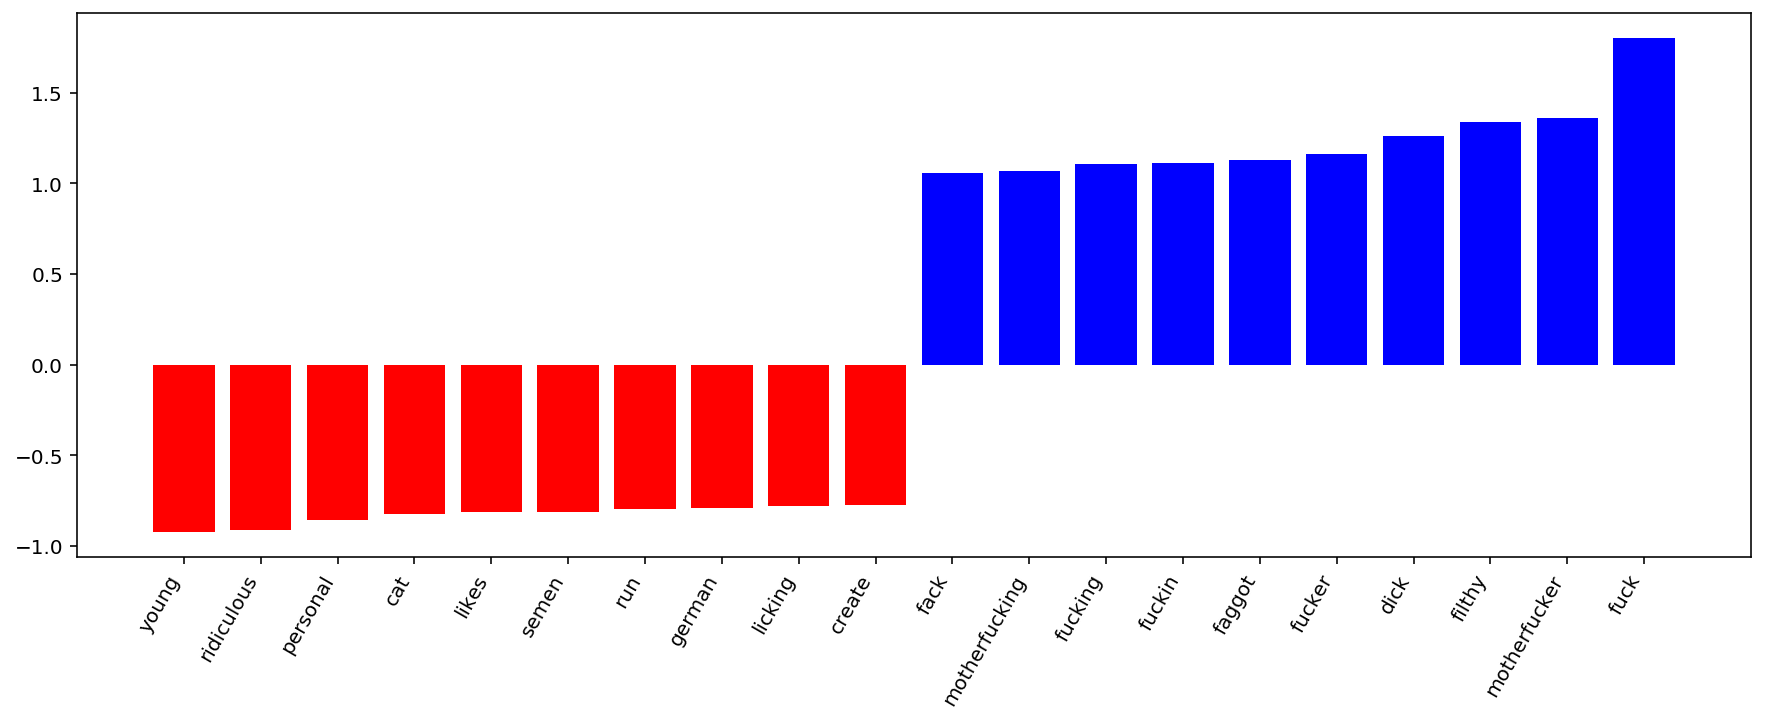

	... Processing obscene
	Training...


array([[1673,  348],
       [ 461, 1795]])

              precision    recall  f1-score   support

           0       0.78      0.83      0.81      2021
           1       0.84      0.80      0.82      2256

    accuracy                           0.81      4277
   macro avg       0.81      0.81      0.81      4277
weighted avg       0.81      0.81      0.81      4277



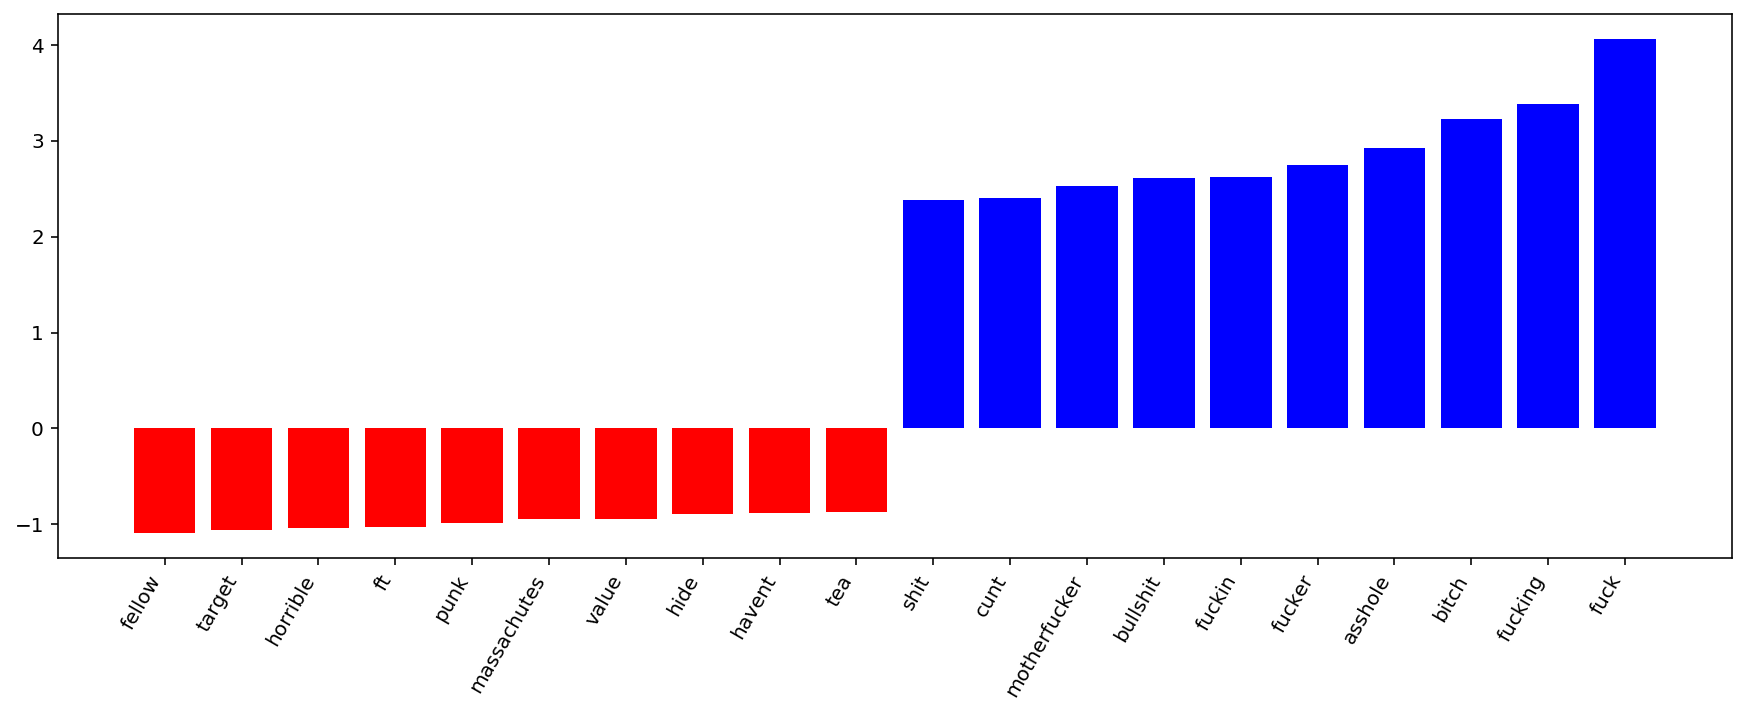

	... Processing threat
	Training...


array([[4137,   23],
       [  80,   37]])

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      4160
           1       0.62      0.32      0.42       117

    accuracy                           0.98      4277
   macro avg       0.80      0.66      0.70      4277
weighted avg       0.97      0.98      0.97      4277



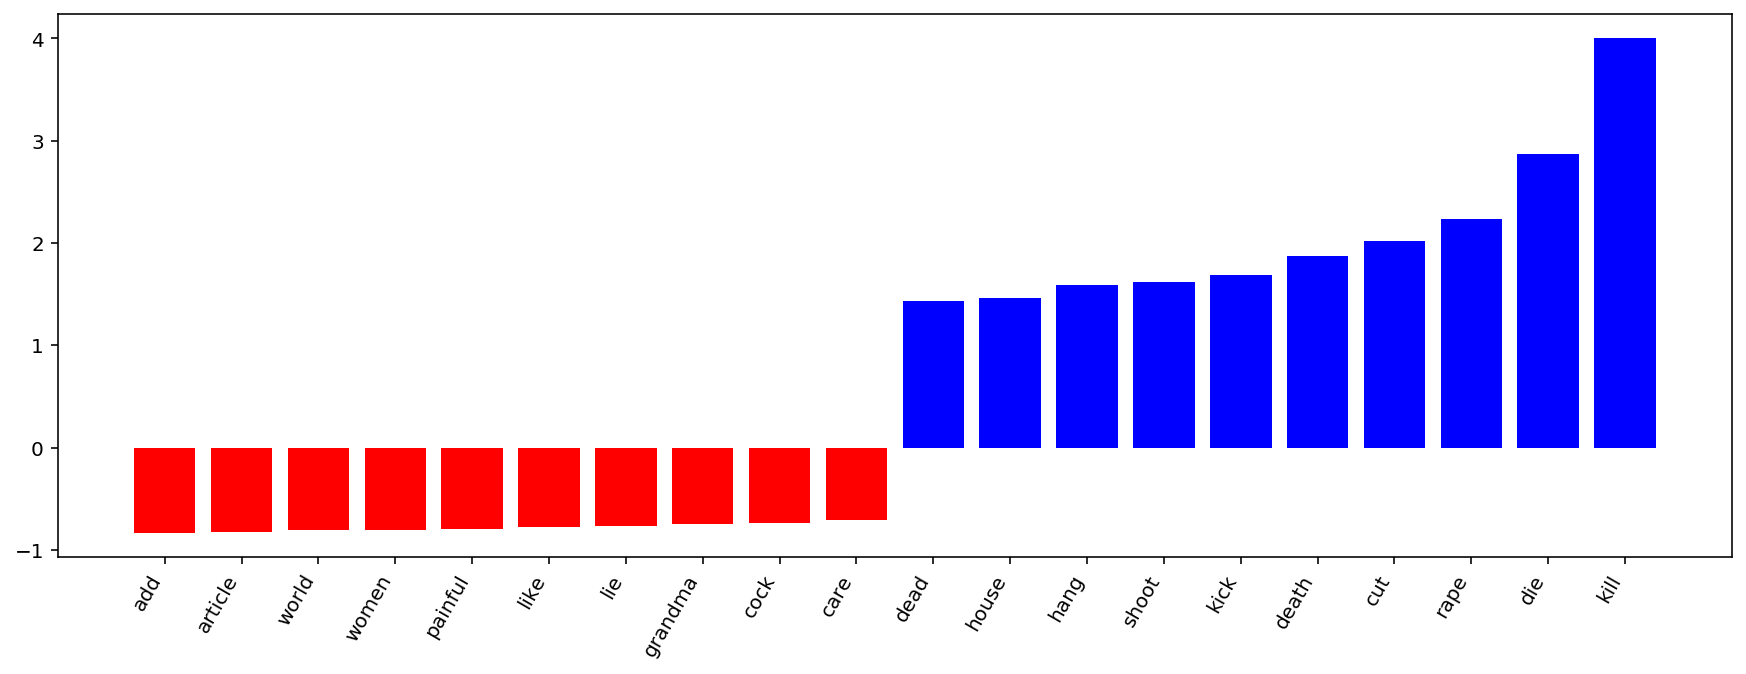

	... Processing insult
	Training...


array([[1656,  503],
       [ 590, 1528]])

              precision    recall  f1-score   support

           0       0.74      0.77      0.75      2159
           1       0.75      0.72      0.74      2118

    accuracy                           0.74      4277
   macro avg       0.74      0.74      0.74      4277
weighted avg       0.74      0.74      0.74      4277



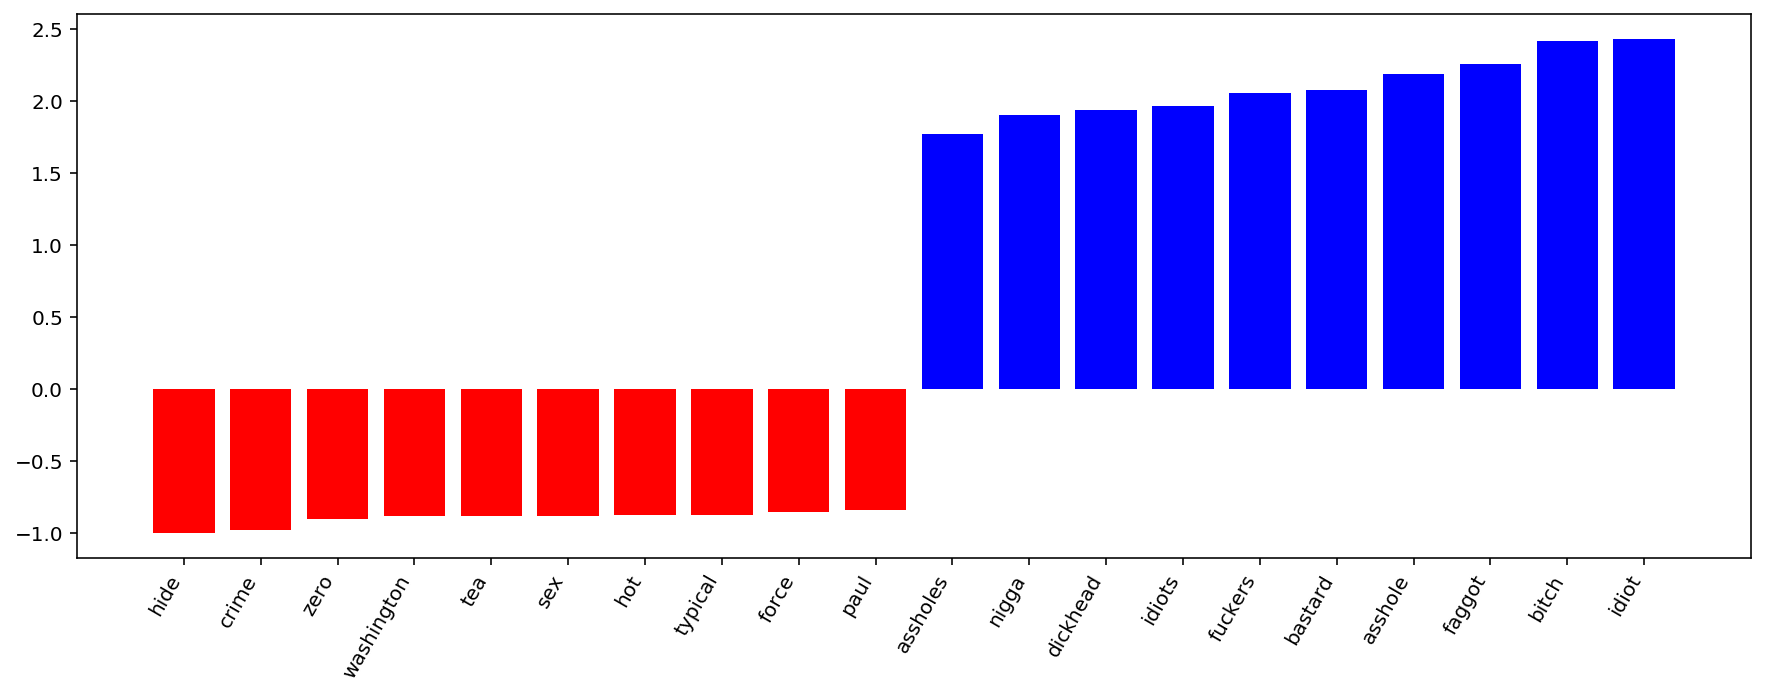

	... Processing identity_hate
	Training...


array([[3822,   72],
       [ 215,  168]])

              precision    recall  f1-score   support

           0       0.95      0.98      0.96      3894
           1       0.70      0.44      0.54       383

    accuracy                           0.93      4277
   macro avg       0.82      0.71      0.75      4277
weighted avg       0.92      0.93      0.93      4277



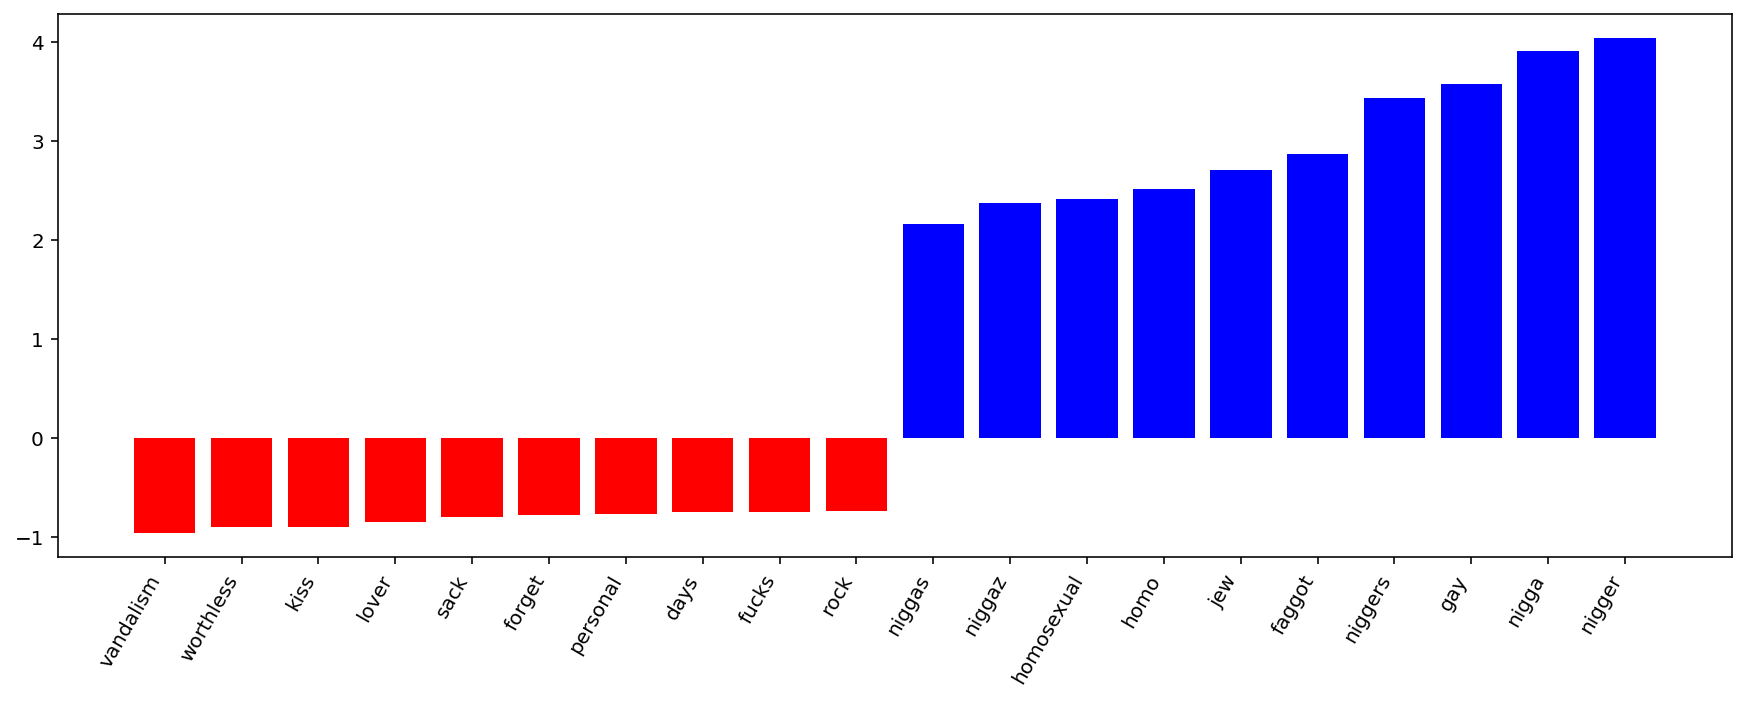


Micro Precision: 78.36%
Micro Recall: 68.56%
Micro F1-score: 73.13%
Average Accuracy: 87.58%


In [23]:
print('Calculating for C = 0.5')

test_TP = list()
test_FP = list()
test_FN = list()
test_TN = list()
test_accuracy = list()
test_precision = list()
test_recall = list()
test_f1_score = list()

for category in categories:
    print('\t... Processing {}'.format(category))

    # train the model
    print('\tTraining...')
    pipelines[2].fit(X_train, y_train[category])
    test_pred = pipelines[2].predict(X_test)

    display(confusion_matrix(y_test[category], test_pred))
    print(classification_report(y_test[category], test_pred))
    
    cm = confusion_matrix(y_test[category], test_pred)
    TN_i = cm[0][0]
    FP_i = cm[0][1]
    FN_i = cm[1][0]
    TP_i = cm[1][1]

    test_TP.append(TP_i)
    test_FP.append(FP_i)
    test_FN.append(FN_i)
    test_TN.append(TN_i)

    accuracy_i = (TP_i + TN_i) / (TP_i + TN_i + FN_i + FP_i)
    test_accuracy.append(accuracy_i)
    
    # feature importance
    feature_importances = Get_Feature_Importances(pipelines[2])
    Plot_Feature_Importances(feature_importances) 
    
    # saving the model
    filename = 'Binary_LR_Level_2_' + str(category) + '.joblib'
    joblib.dump(pipelines[2], filename)

test_avg_accuracy = np.average(test_accuracy)
test_precision = sum(test_TP) / (sum(test_TP) + sum(test_FP))
test_recall = sum(test_TP) / (sum(test_TP) + sum(test_FN))
test_f1_score = 2 * test_precision * test_recall / (test_precision + test_recall)

print("\nMicro Precision: {}%".format(round(100*test_precision, 2)))
print("Micro Recall: {}%".format(round(100*test_recall, 2)))
print("Micro F1-score: {}%".format(round(100*test_f1_score, 2)))
print("Average Accuracy: {}%".format(round(100*test_avg_accuracy, 2)))

##### USING COUNT VECTORIZER

In [24]:
# Count vectorizer pipeline

text = Pipeline([
            ('selector', TextSelector(key='cleaned_comment_text')),
            ('vectorizer', CountVectorizer(stop_words='english'))
        ])

text.fit_transform(X_train)

<17106x30934 sparse matrix of type '<class 'numpy.int64'>'
	with 245326 stored elements in Compressed Sparse Row format>

In [25]:
# creating feature union

feats = FeatureUnion([('text', text), 
                      ('word_count', word_count),
                      ('char_count', char_count),
                      ('word_density', word_density),
                      ('total_length', total_length),
                      ('capitals', capitals), 
                      ('caps_vs_length', caps_vs_length), 
                      ('num_exclamation_marks', num_exclamation_marks), 
                      ('num_unique_words', num_unique_words), 
                      ('words_vs_unique', words_vs_unique)])

feature_processing = Pipeline([('feats', feats)])
feature_processing.fit_transform(X_train)

<17106x30943 sparse matrix of type '<class 'numpy.float64'>'
	with 399280 stored elements in Compressed Sparse Row format>

In [26]:
# defining the model 

range_C = [0.1, 0.2, 0.5, 1.0, 2.0]
pipelines = []

for C  in range_C:
    LR = LogisticRegression(C=C)

    pipeline = Pipeline([
        ('features',feats),
        ('classifier', LR),
    ])
    
    pipelines.append(pipeline)

In [27]:
summary = pd.DataFrame(columns=['C', 'Avg Accuracy - Train', 'Micro Precision - Train', 
                                'Micro Recall - Train', 'Micro F1-score - Train',
                                'Avg Accuracy - Test', 'Micro Precision - Test', 
                                'Micro Recall - Test', 'Micro F1-score - Test'])

In [28]:
# train, predict and evaluate on training and test data

for i in range(len(pipelines)):
    
    print('Calculating for C = ', range_C[i])
    
    train_TP = list()
    train_FP = list()
    train_FN = list()
    train_TN = list()
    train_accuracy = list()
    train_precision = list()
    train_recall = list()
    train_f1_score = list()
    
    test_TP = list()
    test_FP = list()
    test_FN = list()
    test_TN = list()
    test_accuracy = list()
    test_precision = list()
    test_recall = list()
    test_f1_score = list()
    
    for category in categories:
        
        print('\t... Processing {}'.format(category))
        
        # train the model
        print('\tTraining...')
        pipelines[i].fit(X_train, y_train[category])

        print('\t\tCalculating Training Metrics for C = ', range_C[i])
        train_pred = pipelines[i].predict(X_train)
        
        cm = confusion_matrix(y_train[category], train_pred)
        TN_i = cm[0][0]
        FP_i = cm[0][1]
        FN_i = cm[1][0]
        TP_i = cm[1][1]

        train_TP.append(TP_i)
        train_FP.append(FP_i)
        train_FN.append(FN_i)
        train_TN.append(TN_i)
        
        accuracy_i = (TP_i + TN_i) / (TP_i + TN_i + FN_i + FP_i)
        train_accuracy.append(accuracy_i)
        
        print('\t\tCalculating Testing Metrics for C = ', range_C[i])
        test_pred = pipelines[i].predict(X_test)
        
        cm = confusion_matrix(y_test[category], test_pred)
        TN_i = cm[0][0]
        FP_i = cm[0][1]
        FN_i = cm[1][0]
        TP_i = cm[1][1]

        test_TP.append(TP_i)
        test_FP.append(FP_i)
        test_FN.append(FN_i)
        test_TN.append(TN_i)
        
        accuracy_i = (TP_i + TN_i) / (TP_i + TN_i + FN_i + FP_i)
        test_accuracy.append(accuracy_i)
        
    train_avg_accuracy = np.average(train_accuracy)
    train_precision = sum(train_TP) / (sum(train_TP) + sum(train_FP))
    train_recall = sum(train_TP) / (sum(train_TP) + sum(train_FN))
    train_f1_score = 2 * train_precision * train_recall / (train_precision + train_recall)
    
    test_avg_accuracy = np.average(test_accuracy)
    test_precision = sum(test_TP) / (sum(test_TP) + sum(test_FP))
    test_recall = sum(test_TP) / (sum(test_TP) + sum(test_FN))
    test_f1_score = 2 * test_precision * test_recall / (test_precision + test_recall)
    
    summary.at[i, 'C'] = range_C[i]
    summary.at[i, 'Avg Accuracy - Train'] = np.round(100*train_avg_accuracy, 2)
    summary.at[i, 'Micro Precision - Train'] = np.round(100*train_precision, 2)
    summary.at[i, 'Micro Recall - Train'] = np.round(100*train_recall, 2)
    summary.at[i, 'Micro F1-score - Train'] = np.round(100*train_f1_score, 2)
    
    summary.at[i, 'Avg Accuracy - Test'] = np.round(100*test_avg_accuracy, 2)
    summary.at[i, 'Micro Precision - Test'] = np.round(100*test_precision, 2)
    summary.at[i, 'Micro Recall - Test'] = np.round(100*test_recall, 2)
    summary.at[i, 'Micro F1-score - Test'] = np.round(100*test_f1_score, 2)
    
display(summary)

Calculating for C =  0.1
	... Processing severe_toxic
	Training...
		Calculating Training Metrics for C =  0.1
		Calculating Testing Metrics for C =  0.1
	... Processing obscene
	Training...
		Calculating Training Metrics for C =  0.1
		Calculating Testing Metrics for C =  0.1
	... Processing threat
	Training...
		Calculating Training Metrics for C =  0.1
		Calculating Testing Metrics for C =  0.1
	... Processing insult
	Training...
		Calculating Training Metrics for C =  0.1
		Calculating Testing Metrics for C =  0.1
	... Processing identity_hate
	Training...
		Calculating Training Metrics for C =  0.1
		Calculating Testing Metrics for C =  0.1
Calculating for C =  0.2
	... Processing severe_toxic
	Training...
		Calculating Training Metrics for C =  0.2
		Calculating Testing Metrics for C =  0.2
	... Processing obscene
	Training...
		Calculating Training Metrics for C =  0.2
		Calculating Testing Metrics for C =  0.2
	... Processing threat
	Training...
		Calculating Training Metrics f

,C,Avg Accuracy - Train,Micro Precision - Train,Micro Recall - Train,Micro F1-score - Train,Avg Accuracy - Test,Micro Precision - Test,Micro Recall - Test,Micro F1-score - Test
0,0.1,89.23,86.71,67.67,76.02,85.7,76.66,60.38,67.55
1,0.2,90.34,88.35,71.07,78.77,85.77,76.38,61.18,67.94
2,0.5,91.28,89.53,74.08,81.08,85.09,73.62,61.54,67.04
3,1,91.78,89.87,75.97,82.34,84.59,72.02,61.25,66.2
4,2,92.91,92.51,78.25,84.78,84.66,71.76,62.26,66.67


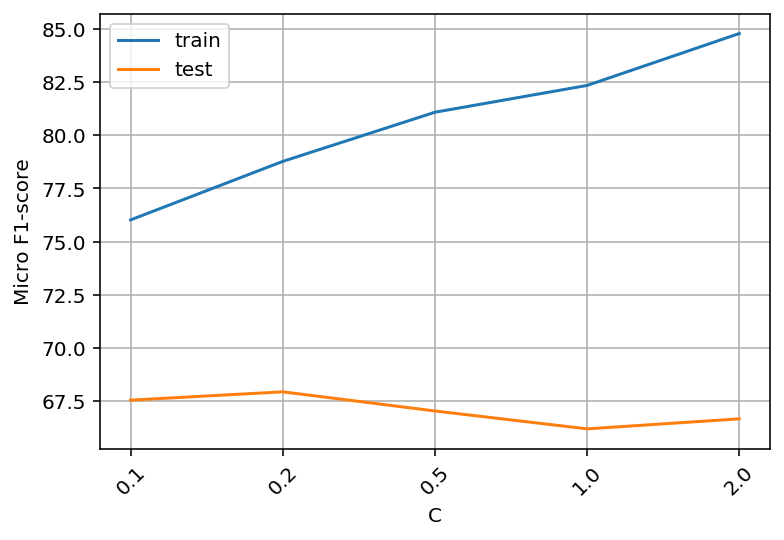

In [29]:
# plot train F1-score and test F1-score

fig = plt.figure(1)
ax  = fig.add_subplot(111)
a = np.arange(len(summary))

plt.plot(summary['Micro F1-score - Train'], label='train')
plt.plot(summary['Micro F1-score - Test'], label='test')
ax.xaxis.set_ticks(a)
ax.xaxis.set_ticklabels(range_C, rotation=45)
plt.xlabel('C')
plt.ylabel('Micro F1-score', rotation=90)
plt.legend()
plt.grid(True)

Since the test score is highest at C = 0.2, we select 0.2 for C.

Calculating for C = 0.2
	... Processing severe_toxic
	Training...


array([[3854,   27],
       [ 343,   53]])

              precision    recall  f1-score   support

           0       0.92      0.99      0.95      3881
           1       0.66      0.13      0.22       396

    accuracy                           0.91      4277
   macro avg       0.79      0.56      0.59      4277
weighted avg       0.89      0.91      0.89      4277



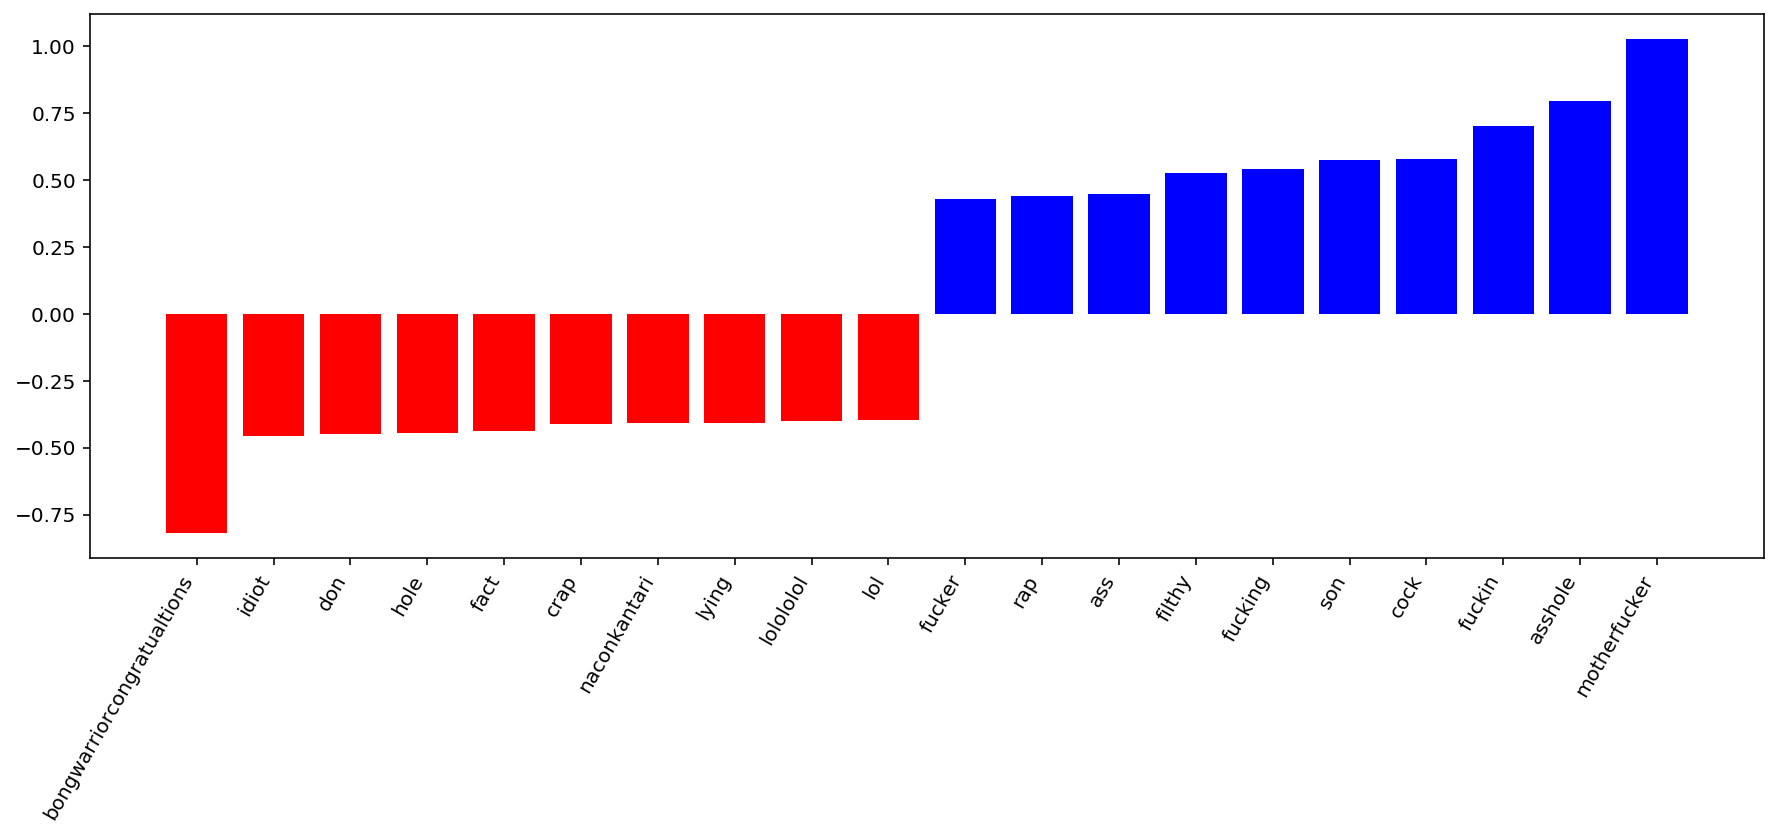

	... Processing obscene
	Training...


array([[1685,  336],
       [ 513, 1743]])

              precision    recall  f1-score   support

           0       0.77      0.83      0.80      2021
           1       0.84      0.77      0.80      2256

    accuracy                           0.80      4277
   macro avg       0.80      0.80      0.80      4277
weighted avg       0.80      0.80      0.80      4277



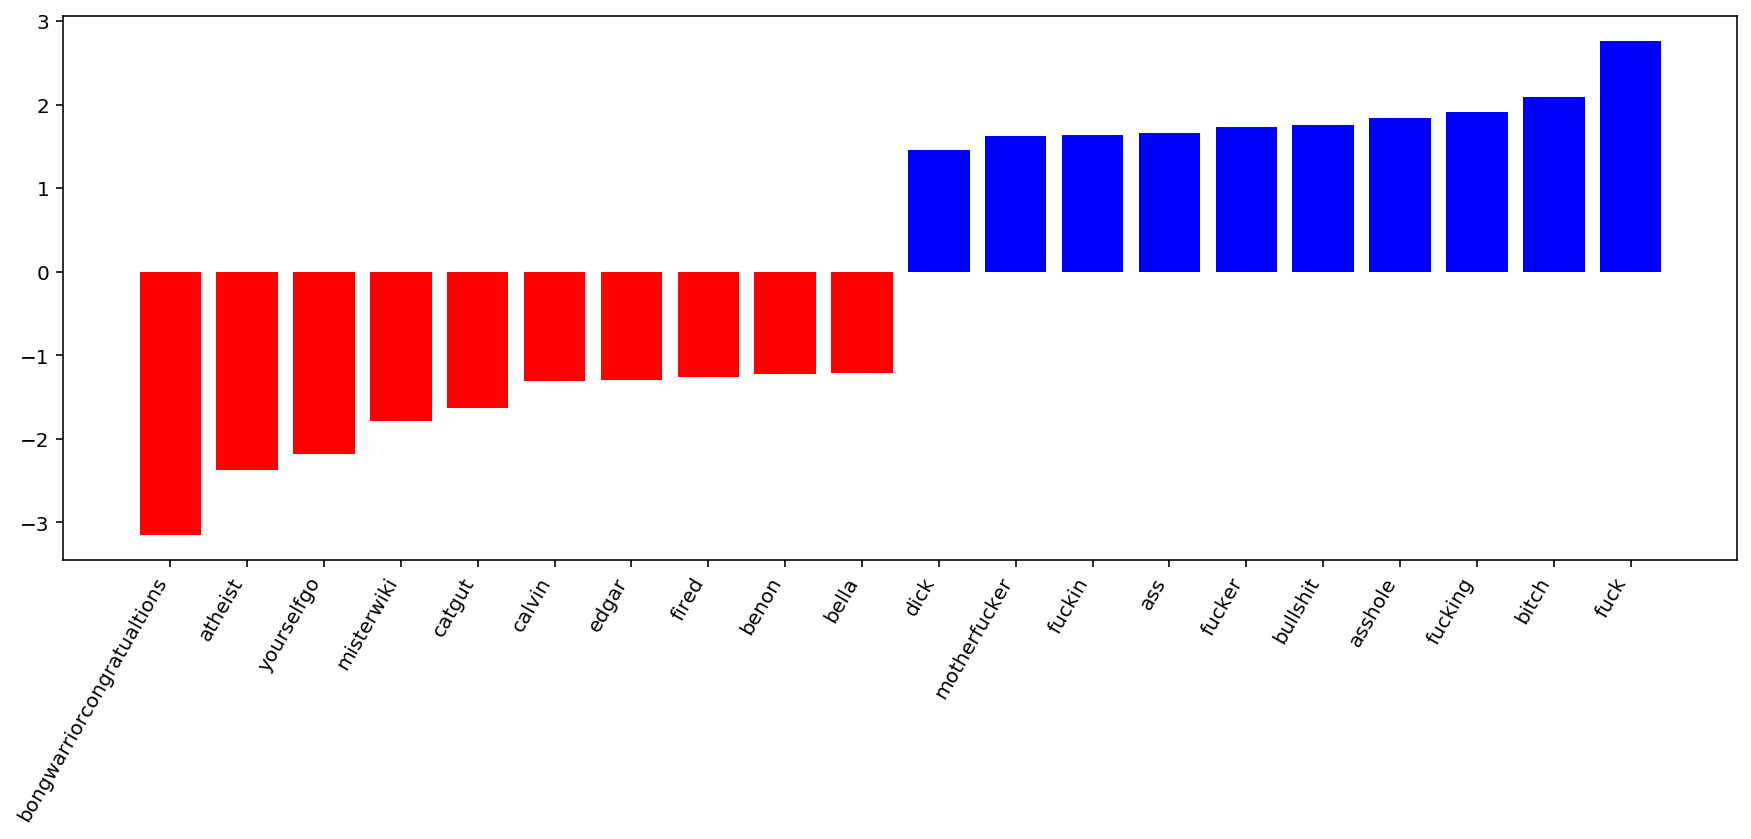

	... Processing threat
	Training...


array([[4128,   32],
       [ 104,   13]])

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      4160
           1       0.29      0.11      0.16       117

    accuracy                           0.97      4277
   macro avg       0.63      0.55      0.57      4277
weighted avg       0.96      0.97      0.96      4277



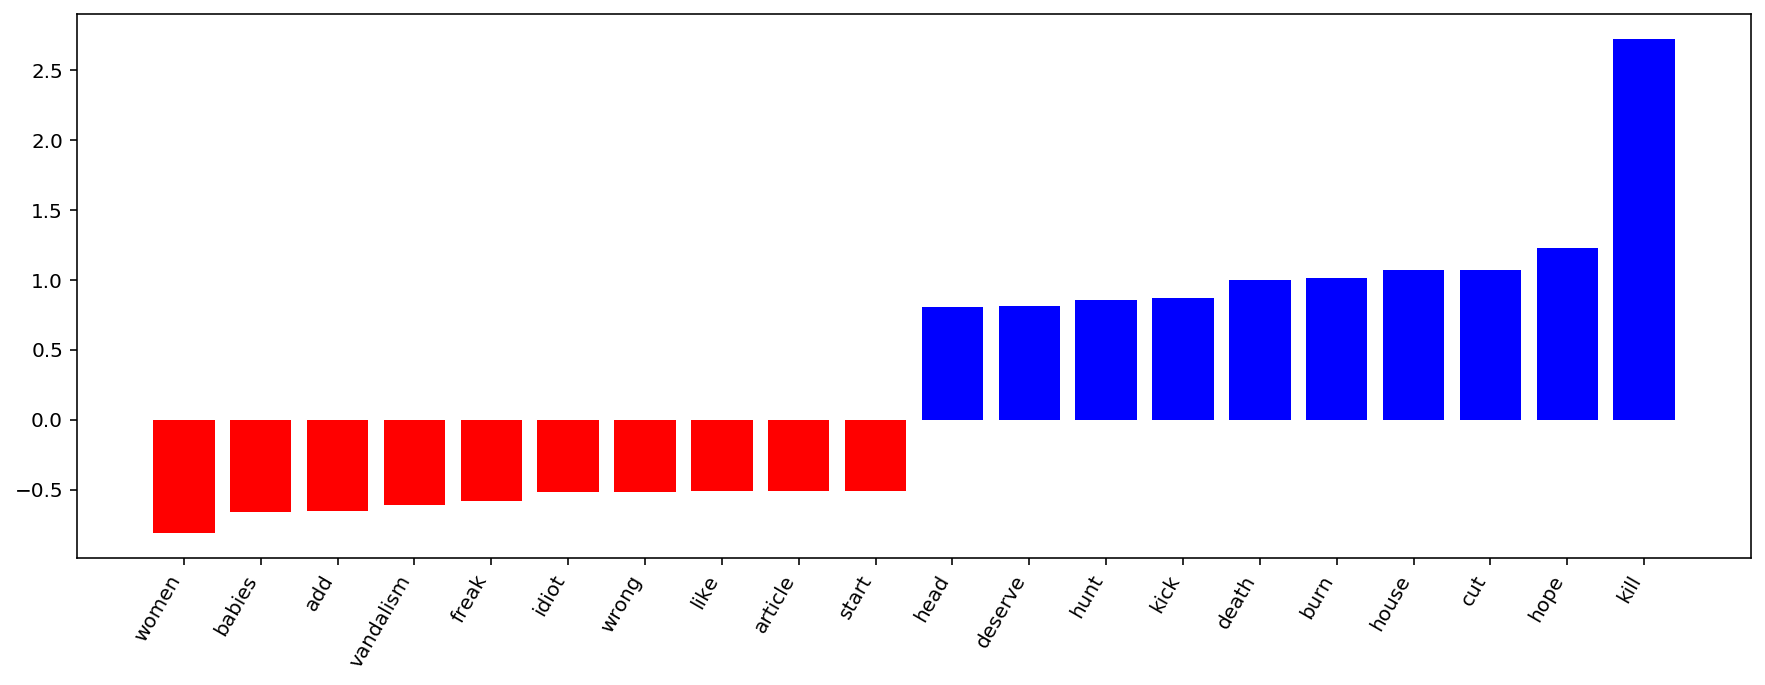

	... Processing insult
	Training...


array([[1581,  578],
       [ 739, 1379]])

              precision    recall  f1-score   support

           0       0.68      0.73      0.71      2159
           1       0.70      0.65      0.68      2118

    accuracy                           0.69      4277
   macro avg       0.69      0.69      0.69      4277
weighted avg       0.69      0.69      0.69      4277



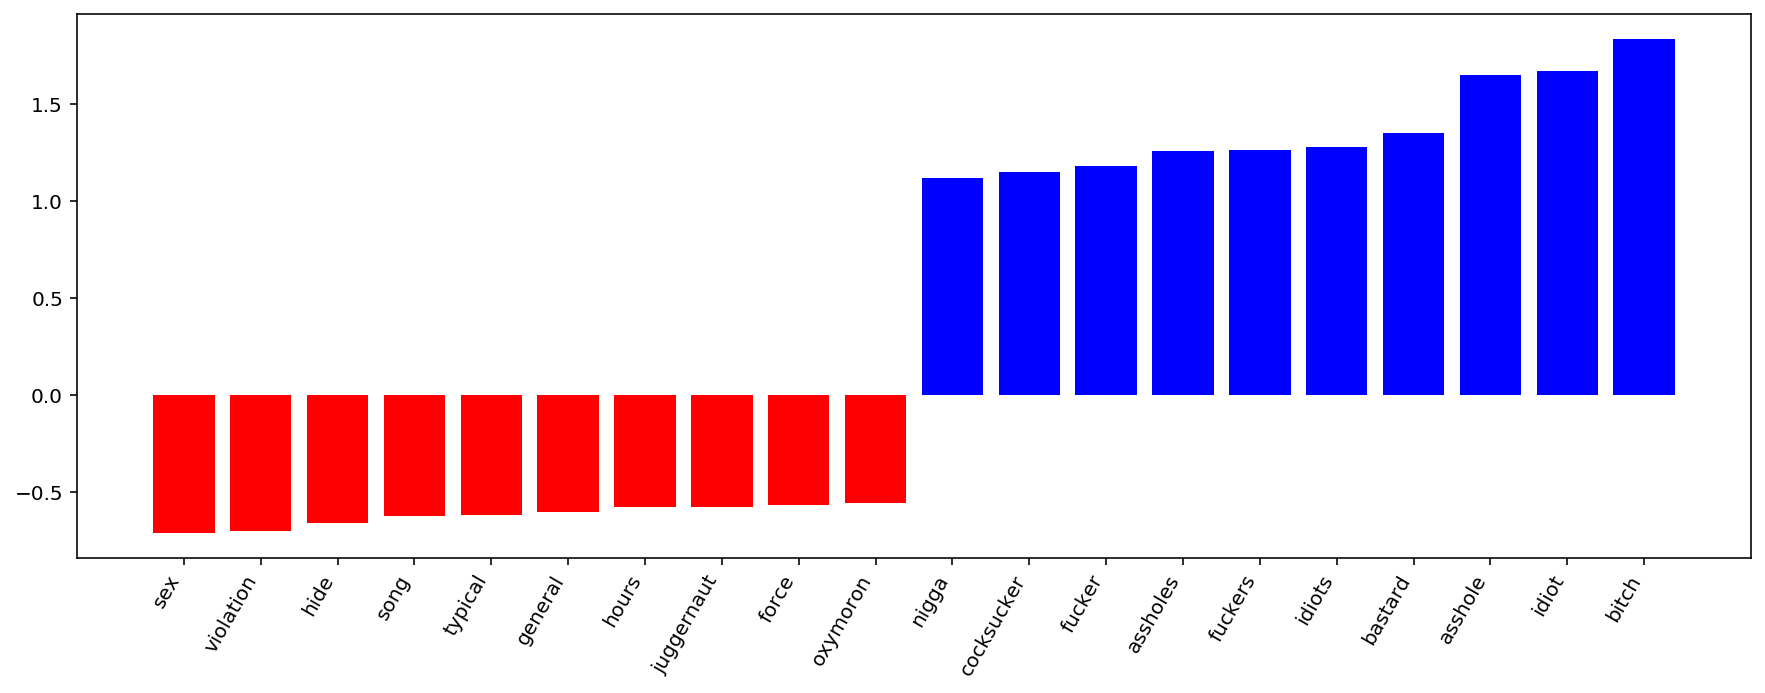

	... Processing identity_hate
	Training...


array([[3870,   24],
       [ 347,   36]])

              precision    recall  f1-score   support

           0       0.92      0.99      0.95      3894
           1       0.60      0.09      0.16       383

    accuracy                           0.91      4277
   macro avg       0.76      0.54      0.56      4277
weighted avg       0.89      0.91      0.88      4277



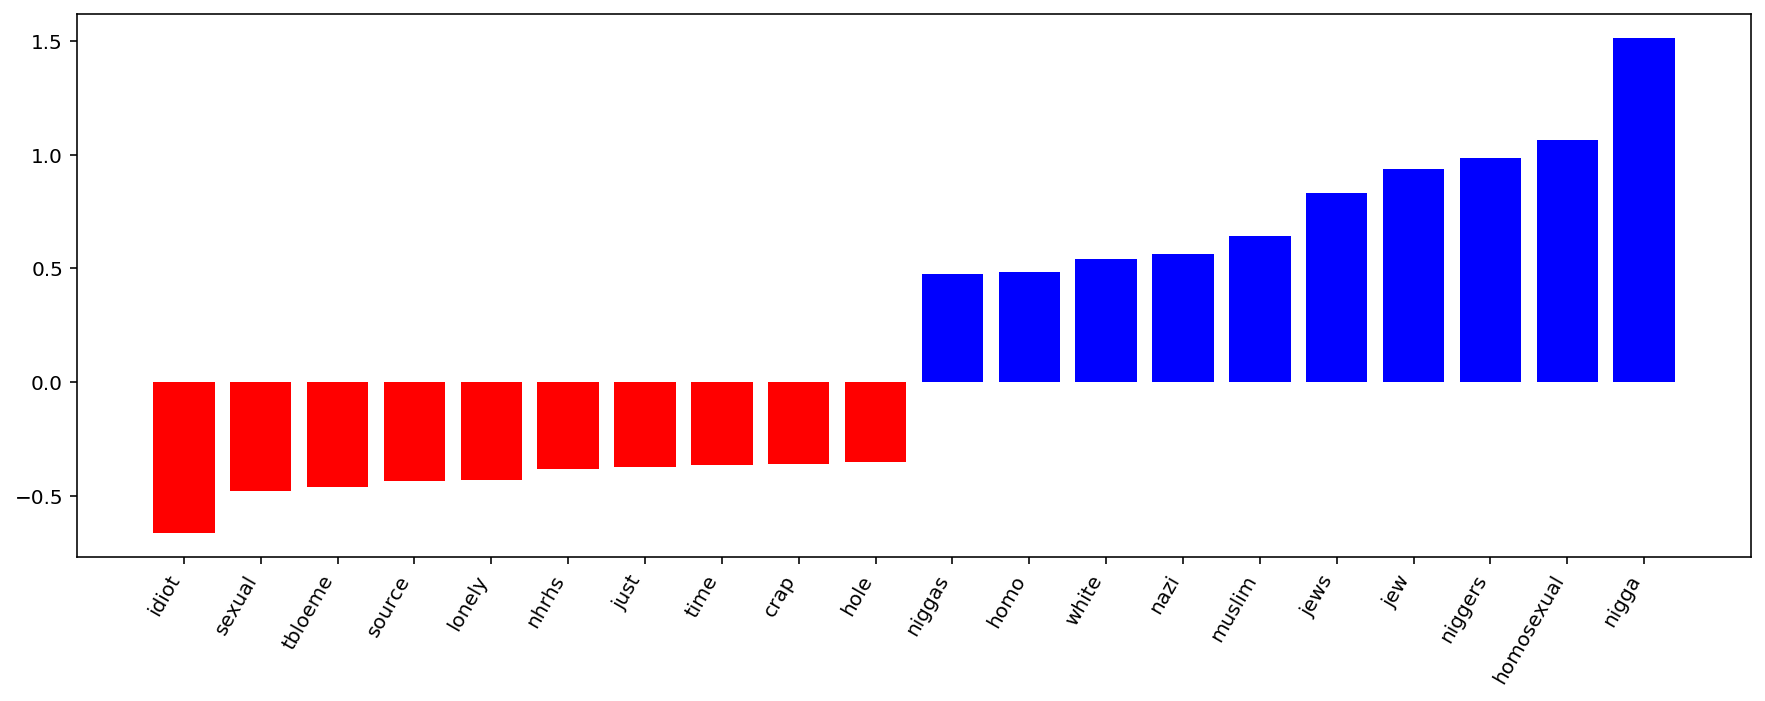


Micro Precision: 76.38%
Micro Recall: 61.18%
Micro F1-score: 67.94%
Average Accuracy: 85.77%


In [30]:
print('Calculating for C = 0.2')

test_TP = list()
test_FP = list()
test_FN = list()
test_TN = list()
test_accuracy = list()
test_precision = list()
test_recall = list()
test_f1_score = list()

for category in categories:
    print('\t... Processing {}'.format(category))

    # train the model
    print('\tTraining...')
    pipelines[1].fit(X_train, y_train[category])
    test_pred = pipelines[1].predict(X_test)

    display(confusion_matrix(y_test[category], test_pred))
    print(classification_report(y_test[category], test_pred))
    
    cm = confusion_matrix(y_test[category], test_pred)
    TN_i = cm[0][0]
    FP_i = cm[0][1]
    FN_i = cm[1][0]
    TP_i = cm[1][1]

    test_TP.append(TP_i)
    test_FP.append(FP_i)
    test_FN.append(FN_i)
    test_TN.append(TN_i)

    accuracy_i = (TP_i + TN_i) / (TP_i + TN_i + FN_i + FP_i)
    test_accuracy.append(accuracy_i)
    
    # feature importance
    feature_importances = Get_Feature_Importances(pipelines[1])
    Plot_Feature_Importances(feature_importances) 
    
    # saving the model
    filename = 'Count_LR_Level_2_' + str(category) + '.joblib'
    joblib.dump(pipelines[1], filename)

test_avg_accuracy = np.average(test_accuracy)
test_precision = sum(test_TP) / (sum(test_TP) + sum(test_FP))
test_recall = sum(test_TP) / (sum(test_TP) + sum(test_FN))
test_f1_score = 2 * test_precision * test_recall / (test_precision + test_recall)

print("\nMicro Precision: {}%".format(round(100*test_precision, 2)))
print("Micro Recall: {}%".format(round(100*test_recall, 2)))
print("Micro F1-score: {}%".format(round(100*test_f1_score, 2)))
print("Average Accuracy: {}%".format(round(100*test_avg_accuracy, 2)))